In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table 
from hugs import primitives as prim
import hugs
from time import time

from astropy.visualization import ZScaleInterval
from kuaizi.display import display_single, SEG_CMAP

In [2]:
config_params = hugs.utils.read_config('../pipe-configs/cosmos-config.yml')

patches = Table([[9813], [30]], names=['tract', 'patch'])

patches['outdir'] = '/scratch/gpfs/jiaxuanl/Data/HSC/hugs-io/'
patches['log_fn'] = '/scratch/gpfs/jiaxuanl/Data/HSC/hugs-io/hugs-pipe.log'

patches['config_fn'] = '../pipe-configs/cosmos-config.yml'
patches['run_name'] = 'hugs-pipe-run'

patches['rerun_path'] = None

tract, p1, p2 = patches['tract'], int(patches['patch'][0]), int(patches['patch'][-1])
seed = [int(time())]
p = patches[0]

In [3]:
config = hugs.PipeConfig(run_name=p['run_name'], 
                         config_fn=p['config_fn'],
                         random_state=seed[0], 
                         log_fn=p['log_fn'],
                         rerun_path=p['rerun_path'])

In [7]:
dataId = dict(tract=9813, patch=30)
exp = config.butler.get(
    'deepCoadd_calexp', 
                  dataId,
                  skymap='hsc_rings_v1', 
                        band='i')

In [16]:
mi = exp.getMaskedImage()
mask = exp.getMask()

In [17]:
img = exp.getImage().getArray()

In [38]:
psf_sigma = hugs.utils.get_psf_sigma(exp)
# mi_smooth = mi
mi_smooth = hugs.imtools.smooth_gauss(mi, psf_sigma, use_scipy=True)

In [39]:
fpset_low = prim.image_threshold(mi_smooth, 
                                 thresh=3.0,
                                 mask=mask, 
                                 plane_name='THRESH_LOW',
                                 rgrow=4)

fpset_high = prim.image_threshold(mi_smooth, 
                                 thresh=28.0,
                                 mask=mask, 
                                 plane_name='THRESH_HIGH',
                                 rgrow=15)

In [40]:
# seg_high = get_fp_array(fpset_high)

In [41]:
seg_high = fpset_high.insertIntoImage().getArray().copy()
seg_high = seg_high.astype(float)
seg_high[seg_high > 0.0] = 1.0

seg_low = fpset_low.insertIntoImage().getArray().copy()
seg_low = seg_low.astype(float)
seg_low[seg_low > 0.0] = 1.0

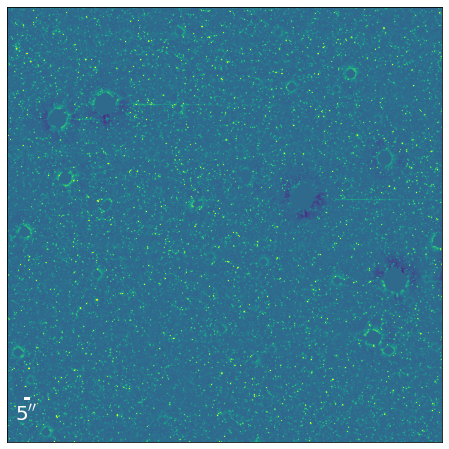

In [31]:
display_single(img * ~(seg_high.astype(bool)));

In [42]:
exp_clean = prim.clean(exp, fpset_low, rgrow=10, max_frac_high_thresh=0.15)

In [43]:
def show_step(img, ax, vmin, vmax, title, seg=None, alpha=0.6, cmap=plt.cm.gnuplot):
    
    ax.imshow(img, cmap='gray_r', vmin=vmin, vmax=vmax, origin='lower')
    
    if seg is not None:
        if type(seg) is not list:
            seg = [seg]
        if type(alpha) is not list:    
            alpha = [alpha]*len(seg)  
        for s, a in zip(seg, alpha): 
            ax.imshow(s, alpha=a, cmap=cmap, vmin=0, vmax=1, origin='lower')
            
    ax.set_title(title, fontsize=15)
            
def get_fp_array(fpset):
    seg = fpset.insertIntoImage().getArray().copy()
    seg = seg.astype(float)
    seg[seg==0] = np.nan
    seg[~np.isnan(seg)] = 1.0
    return seg

zscale = ZScaleInterval()

In [44]:
img = exp.getImage().getArray()
img_clean = exp_clean.getImage().getArray()
seg_high = get_fp_array(fpset_high)
seg_low = get_fp_array(fpset_low)
vmin, vmax = zscale.get_limits(img)

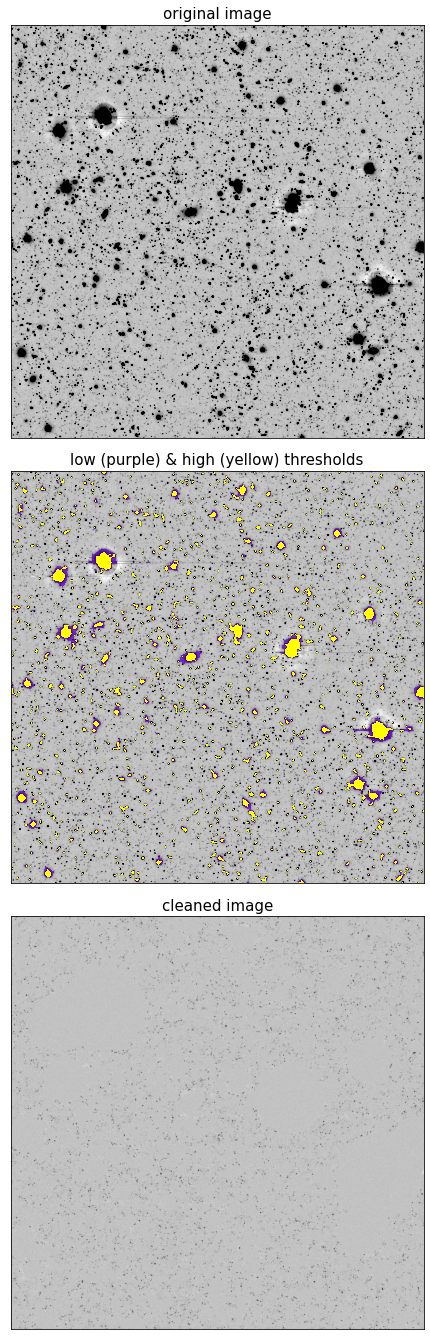

In [45]:
fig, axes = plt.subplots(3, 1, figsize=(8, 24), 
                         subplot_kw=dict(xticks=[], yticks=[], aspect='equal'))
fig.subplots_adjust(hspace=0.08)
show_step(img, axes[0], vmin, vmax, 'original image')
show_step(img, axes[1], vmin, vmax, 'low (purple) & high (yellow) thresholds', 
          [seg_low*0.15, seg_high*1], [0.7, 1])
show_step(img_clean, axes[2], vmin, vmax, 'cleaned image')

In [8]:
config_params = hugs.utils.read_config('../pipe-configs/cosmos-config.yml')

patches = Table([[9813], [30]], names=['tract', 'patch'])

patches['outdir'] = '/scratch/gpfs/jiaxuanl/Data/HSC/hugs-io/'
patches['log_fn'] = '/scratch/gpfs/jiaxuanl/Data/HSC/hugs-io/hugs-pipe.log'

patches['config_fn'] = '../pipe-configs/cosmos-config.yml'
patches['run_name'] = 'hugs-pipe-run'

patches['rerun_path'] = None

tract, p1, p2 = patches['tract'], int(patches['patch'][0]), int(patches['patch'][-1])
seed = [int(time())]
p = patches[0]

In [9]:
config = hugs.PipeConfig(run_name=p['run_name'], 
                         config_fn=p['config_fn'],
                         random_state=seed[0], 
                         log_fn=p['log_fn'],
                         rerun_path=p['rerun_path'])

In [10]:
config.set_patch_id(p['tract'], p['patch'])

INFO: starting hugs: 9813 | 30
INFO: growing clean footprints with rgrow = 20.0


In [11]:
from hugs.pipeline import next_gen_search

In [12]:
exp_clean, config = next_gen_search.run(config, False)

INFO: making mask using i-band
INFO: good data fraction = 1.00
INFO: thresh type set to SB
INFO: performing low threshold at 11.93 sigma
INFO: performing high threshold at 119.30 sigma
INFO: generating cleaned exposure


In [6]:
results = next_gen_search.run(config, False)

INFO: making mask using i-band
INFO: good data fraction = 1.00
INFO: thresh type set to SB
INFO: performing low threshold at 11.93 sigma
INFO: performing high threshold at 119.30 sigma
INFO: generating cleaned exposure
INFO: removed small sources with HSC detection map
INFO: running sep_point_sources
INFO: applying mask
INFO: smoothing with kernel with fwhm = 0.81 arcsec
INFO: detecting with a threshold of 1.5 x background
INFO: found 7084 sources
INFO: measuring source parameters
INFO: generating and applying sep ellipse mask
INFO: building ellipse mask
INFO: 7.07% of patch masked
INFO: detecting in g-band
INFO: cleaning non-detection bands
INFO: measuring in g-band

running 
-------
/home/jiaxuanl/Research/Packages/sextractor-2.25.0/src/sex -c /home/jiaxuanl/Research/Packages/hugs/hugs/sextractor/config/hugs-default.sex /scratch/gpfs/jiaxuanl/Data/HSC/sextractor-io/exp-9813-30-g.fits[1] -CATALOG_NAME /scratch/gpfs/jiaxuanl/Data/HSC/sextractor-io/sex-9813-30-g.cat -PIXEL_SCALE 0.168 -

In [8]:
pm = results.hugs_exp.patch_meta

In [10]:
patch_meta = hugs.utils.PatchMeta(
    x0 = pm.x0,
    y0 = pm.y0,
    small_frac = pm.small_frac,
    cleaned_frac = pm.cleaned_frac,
    bright_obj_frac = pm.bright_obj_frac,
    good_data_frac = pm.good_data_frac
)

meta_data = [
    config.run_name,
    config.tract,
    config.patch,
    patch_meta,
]

if results.success:
    df = results.sources.to_pandas()
    df['flags'] = df['flags'].astype(int)
else:
    df = None

# config.reset_mask_planes()
# config.logger.info('writing results to database')
# return results.success, df, meta_data, synth_ids

In [19]:
from kuaizi.display import draw_circles

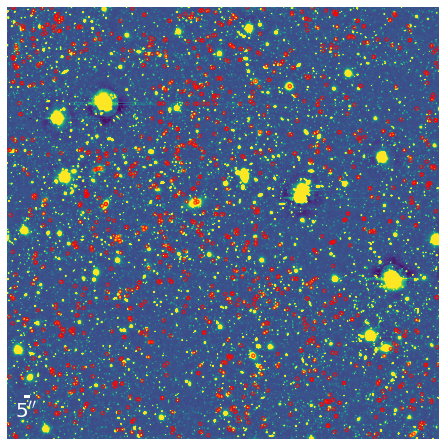

In [25]:
draw_circles(img, obj_cat[:], colnames=['x_image', 'y_image'])

In [39]:
obj = obj_cat[218]
half_width = 50

In [40]:
img_cut = img[int(obj['y_image'])-half_width:int(obj['y_image'])+half_width, 
    int(obj['x_image'])-half_width:int(obj['x_image'])+half_width]

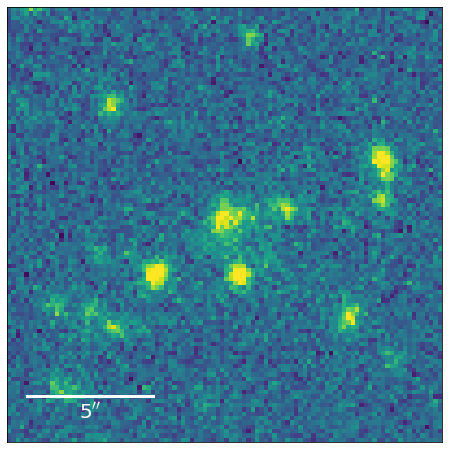

In [41]:
display_single(img_cut);

In [20]:
obj_cat = Table.from_pandas(df)

In [7]:
config.exp_clean

In [8]:
img_clean = config.exp_clean.getImage().getArray()

In [46]:
img_clean.shape

(4200, 4200)

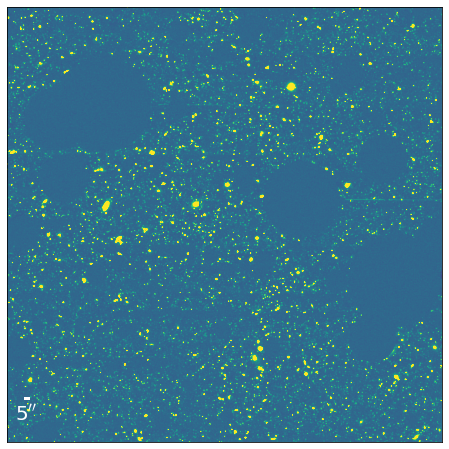

In [9]:
display_single(img_clean);

In [58]:
30 // 9

3